In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.cloud import storage
from astropy.io import fits
from sunpy.map import Map
from astropy import units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
from sunpy.map import header_helper
from sunpy.physics.differential_rotation import differential_rotate
import sunpy.coordinates

In [2]:
index = pd.read_csv("gs://fdl-mag-sdo-prepped/index.csv")

In [3]:
file1 = index.loc[0, 'filepath']
file2 = index.loc[3, 'filepath']

In [4]:
client = storage.Client()
bucket = client.get_bucket('fdl-mag-sdo-prepped')

In [5]:
blob = storage.Blob(file1.split('\\')[-1], bucket)
blob.download_to_filename('tmp.fits')
HMI_fits = fits.open('tmp.fits', cache=False)
HMI_fits.verify('fix')
dataHMI = HMI_fits[1].data

# Assemble Sunpy map
HMImap1 = Map(HMI_fits[1].data, HMI_fits[1].header)

In [6]:
blob = storage.Blob(file2.split('\\')[-1], bucket)
blob.download_to_filename('tmp.fits')
HMI_fits = fits.open('tmp.fits', cache=False)
HMI_fits.verify('fix')
dataHMI = HMI_fits[1].data

# Assemble Sunpy map
HMImap2 = Map(HMI_fits[1].data, HMI_fits[1].header)

In [7]:
time_delta = HMImap2.date - HMImap1.date

In [13]:
observer = HMImap1.observer_coordinate

In [14]:
# differential rotation by bring HMImap2 observer to HMImap1 observer
HMImap2_diff = differential_rotate(HMImap2, observer=observer)

In [30]:
# replace nan by zero 
np.nan_to_num(HMImap2_diff.data, copy=False)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

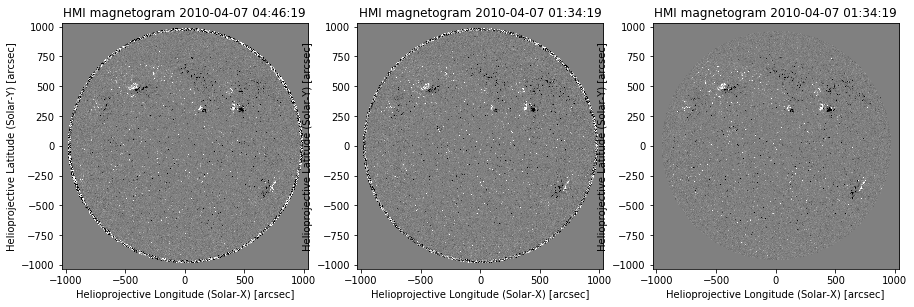

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
HMImap2.plot(vmin=-100, vmax=100,  axes=ax[0])
HMImap1.plot(vmin=-100, vmax=100, axes=ax[1])
HMImap2_diff.plot(vmin=-100, vmax=100, axes=ax[2])

In [36]:
# crop the three HMI maps:
bl = SkyCoord(300*u.arcsec, 200*u.arcsec, frame=HMImap1.coordinate_frame)
tr = SkyCoord(600*u.arcsec, 500*u.arcsec, frame=HMImap1.coordinate_frame)
HMImap1_crop = HMImap1.submap(bl, tr)
bl = SkyCoord(300*u.arcsec, 200*u.arcsec, frame=HMImap2.coordinate_frame)
tr = SkyCoord(600*u.arcsec, 500*u.arcsec, frame=HMImap2.coordinate_frame)
HMImap2_crop = HMImap2.submap(bl, tr)
bl = SkyCoord(300*u.arcsec, 200*u.arcsec, frame=HMImap2_diff.coordinate_frame)
tr = SkyCoord(600*u.arcsec, 500*u.arcsec, frame=HMImap2_diff.coordinate_frame)
HMImap2_crop_diff = HMImap2_diff.submap(bl, tr)

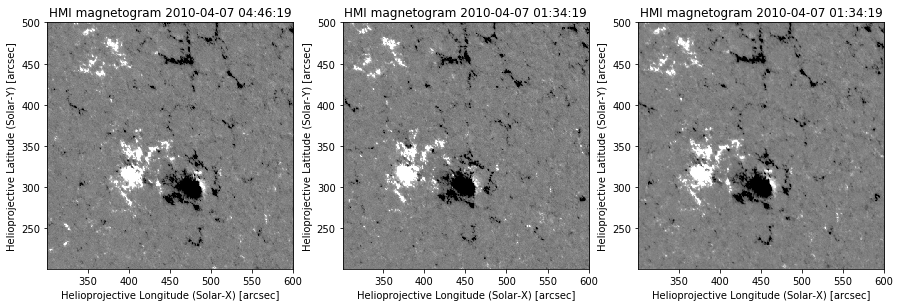

In [54]:
# crop the three maps
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
ax[0].title.set_text('Source Before Differential Rotation')
ax[1].title.set_text('Target')
ax[2].title.set_text('Source After Differential Rotation')
HMImap2_crop.plot(vmin=-100, vmax=100,  axes=ax[0])
HMImap1_crop.plot(vmin=-100, vmax=100, axes=ax[1])
HMImap2_crop_diff.plot(vmin=-100, vmax=100, axes=ax[2])

In [42]:
# compute difference of data:
print((HMImap2_crop_diff.data - HMImap1_crop.data).mean())
print((HMImap2_crop.data - HMImap1_crop.data).mean())

0.033524173924424305
0.3883563924033502


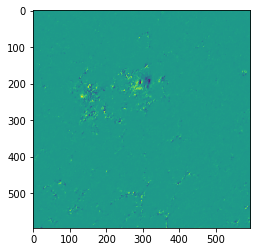

In [55]:
# difference in mag field on the crop after rotation:
plt.imshow(HMImap2_crop_diff.data - HMImap1_crop.data)

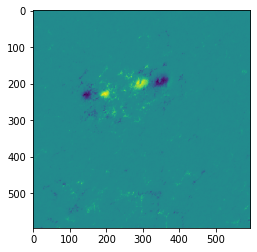

In [57]:
# difference in mag field on the crop before rotation:
plt.imshow(HMImap2_crop.data - HMImap1_crop.data)